# Inspect DDI Train data to test rules

Notebook to test Parser, rules and features for the DDI Train dataset.

> NOTE: StanfordCoreNLP needs to be running on a terminal before using the noteboo. Use the following command:
```bash
java -mx4g -cp 'resources/stanford-corenlp/*' edu.stanford.nlp.pipeline.StanfordCoreNLPServer
```

In [1]:
# !/usr/bin/python3
from graphviz import Digraph
from nltk.parse.corenlp import CoreNLPDependencyParser
from os import listdir, system, path, makedirs
from xml.dom.minidom import parse
from tqdm import tqdm
import pickle
import pandas as pd

In [2]:
inputdir = "data/Train"
outputfile = "data/tmp/task9.2_BASELINE_999.txt"
DependencyParser = CoreNLPDependencyParser(url="http://localhost:9000")
import DDI_ML as ddi

In [3]:
training_data = []
entities = {}
files = listdir(inputdir)
for f in tqdm(files[:]):
    # Parse XML file
    sentences = ddi.parseXML(f"{inputdir}/{f}")
    for s in sentences:
        # get sentence id/text
        sid = s.attributes["id"].value
        stext = s.attributes["text"].value
        if not stext:  # Do not process if sentence is empty
            continue

        # load sentence entities into a dictionary
        ents = s.getElementsByTagName("entity")
        for e in ents:
            id = e.attributes["id"].value
            offs = e.attributes["charOffset"].value.split("-")
            text = e.attributes["text"].value
            entities[id] = {"offset": offs, "text": text}

#         # Tokenize, tag, and parse sentence
#         analysis = ddi.analyze(stext)
        
#         verbs = sorted(
#             [analysis.nodes[n] for n in analysis.nodes if "VB" in analysis.nodes[n]["tag"]],
#             key=lambda x: x["head"]
#         )
#         verb = verbs[0] if len(verbs) else None
        verb = None

        training_data.append((sid, stext, verb))

100%|██████████| 629/629 [00:02<00:00, 309.42it/s]


--------------------------------------
--------------------------------------
--------------------------------------

In [4]:
with open("resources/train_goldDDI.txt","r") as fp:
    lines = fp.readlines()
ents = [line.replace("\n","").split("|") for line in lines]
ents

df = pd.DataFrame(ents, columns=["sentence","e1","e2","is_DDI","DDI_type"])
print(df.shape)
df.groupby("DDI_type").size()

(25089, 5)


DDI_type
advise         707
effect        1525
int            186
mechanism     1118
null         21553
dtype: int64

In [5]:
df_ddi = df[df["DDI_type"] != "null"]
sents = df_ddi["sentence"].values
df_ddi.head()

,sentence,e1,e2,is_DDI,DDI_type
9,DDI-DrugBank.d542.s0,DDI-DrugBank.d542.s0.e3,DDI-DrugBank.d542.s0.e4,1,effect
12,DDI-DrugBank.d542.s1,DDI-DrugBank.d542.s1.e1,DDI-DrugBank.d542.s1.e2,1,mechanism
13,DDI-DrugBank.d359.s1,DDI-DrugBank.d359.s1.e0,DDI-DrugBank.d359.s1.e1,1,advise
14,DDI-DrugBank.d359.s1,DDI-DrugBank.d359.s1.e0,DDI-DrugBank.d359.s1.e2,1,advise
16,DDI-DrugBank.d359.s2,DDI-DrugBank.d359.s2.e0,DDI-DrugBank.d359.s2.e1,1,int


In [6]:
_data = [[t[0], t[1], t[2]["lemma"] if t[2] else None] for t in training_data]
df_verb = pd.DataFrame(_data, columns=["sentence","text","verb"])
df_verb.head()

,sentence,text,verb
0,DDI-DrugBank.d542.s0,Interactions for Vitamin B3 (Niacin): Antihype...,None
1,DDI-DrugBank.d542.s1,Aspirin: Concomitant aspirin may decrease the ...,None
2,DDI-DrugBank.d542.s2,The clinical relevance of this finding is uncl...,None
3,DDI-DrugBank.d542.s3,Other: Concomitant alcohol or hot drinks may i...,None
4,DDI-DrugBank.d359.s0,PEGANONE used in combination with other drugs ...,None


In [7]:
df = df_ddi.merge(df_verb.iloc[:,:-1], on="sentence", how="inner")
df.sort_values(by="DDI_type", inplace=True)
df["e1"] = df["e1"].apply(lambda x: entities[x]["text"])
df["e2"] = df["e2"].apply(lambda x: entities[x]["text"])
df.head()

,sentence,e1,e2,is_DDI,DDI_type,text
2505,DDI-DrugBank.d558.s25,serotonin reuptake inhibitors,TIKOSYN,1,advise,"Inhibitors of this isoenzyme (e.g., macrolide ..."
1833,DDI-DrugBank.d3.s10,TORADOL,probenecid,1,advise,"Therefore, concomitant use of TORADOL and prob..."
1992,DDI-DrugBank.d521.s1,glimepiride,Magan,1,advise,"Before taking glimepiride, tell your doctor if..."
2419,DDI-DrugBank.d410.s2,Sumatriptan,D.H.E. 45,1,advise,Sumatriptan and D.H.E. 45 (dihydroergotamine ...
2420,DDI-DrugBank.d410.s2,Sumatriptan,dihydroergotamine mesylate,1,advise,Sumatriptan and D.H.E. 45 (dihydroergotamine ...


--------------------------------------
-------------------------------------
-------------------------------------
------------------------------------

['DDI-DrugBank.d430.s0']
['Intravenous ranitidine was shown to double the bioavailability of oral alendronate.']
['ranitidine']
['alendronate']


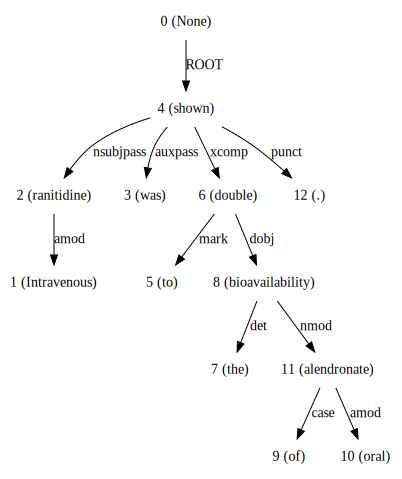

In [8]:
mechanism = df[df["DDI_type"] == "mechanism"]
row = mechanism.sample(1, random_state=44)
print(row["sentence"].values)
print(row["text"].values)
print(row["e1"].values)
print(row["e2"].values)
analysis = ddi.analyze(row["text"].values[0])
analysis

In [9]:
n0 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d430.s0.e0")
n1 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d430.s0.e1")
n0, n1

({'address': 2,
  'word': 'ranitidine',
  'lemma': 'ranitidine',
  'ctag': 'NN',
  'tag': 'NN',
  'feats': '_',
  'head': 4,
  'deps': defaultdict(list, {'amod': [1]}),
  'rel': 'nsubjpass'},
 {'address': 11,
  'word': 'alendronate',
  'lemma': 'alendronate',
  'ctag': 'NN',
  'tag': 'NN',
  'feats': '_',
  'head': 8,
  'deps': defaultdict(list, {'case': [9], 'amod': [10]}),
  'rel': 'nmod'})

In [10]:
v0 = ddi.get_verb_ancestor(analysis, n0)
v1 = ddi.get_verb_ancestor(analysis, n1)
v0, v1

({'address': 4,
  'word': 'shown',
  'lemma': 'show',
  'ctag': 'VBN',
  'tag': 'VBN',
  'feats': '_',
  'head': 0,
  'deps': defaultdict(list,
              {'nsubjpass': [2], 'auxpass': [3], 'xcomp': [6], 'punct': [12]}),
  'rel': 'ROOT'},
 {'address': 6,
  'word': 'double',
  'lemma': 'double',
  'ctag': 'VB',
  'tag': 'VB',
  'feats': '_',
  'head': 4,
  'deps': defaultdict(list, {'mark': [5], 'dobj': [8]}),
  'rel': 'xcomp'})

In [11]:
[v1["address"]] in v0["deps"].values()

True

-----------------------------------
-----------------------------------
-----------------------------------
-----------------------------------

['DDI-DrugBank.d400.s5']
['This interaction should be given consideration in patients taking NSAIDs concomitantly with ACE inhibitors.']
['NSAIDs']
['ACE inhibitors']


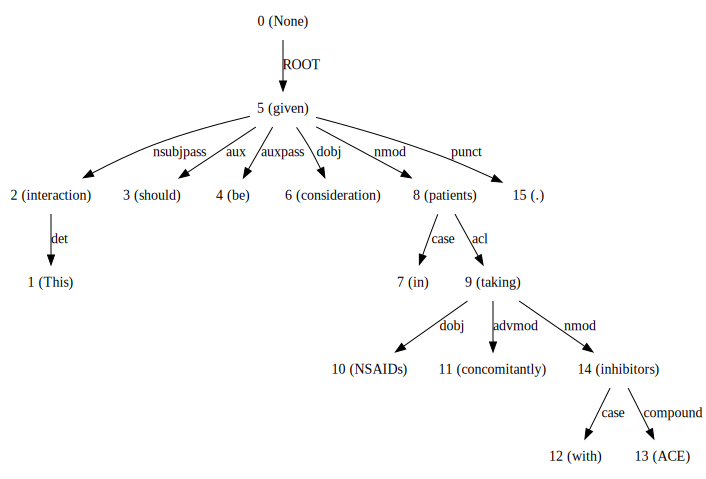

In [21]:
advise = df[df["DDI_type"] == "advise"]
row = advise.sample(1, random_state=42)
print(row["sentence"].values)
print(row["text"].values)
print(row["e1"].values)
print(row["e2"].values)
analysis = ddi.analyze(row["text"].values[0])
analysis

In [13]:
n0 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d400.s5.e0")
n1 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d400.s5.e1")
v0 = ddi.get_verb_ancestor(analysis, n0)
v1 = ddi.get_verb_ancestor(analysis, n1)
n0, n1, v0, v1

({'address': 10,
  'word': 'NSAIDs',
  'lemma': 'nsaid',
  'ctag': 'NNS',
  'tag': 'NNS',
  'feats': '_',
  'head': 9,
  'deps': defaultdict(list, {}),
  'rel': 'dobj'},
 {'address': 14,
  'word': 'inhibitors',
  'lemma': 'inhibitor',
  'ctag': 'NNS',
  'tag': 'NNS',
  'feats': '_',
  'head': 9,
  'deps': defaultdict(list, {'case': [12], 'compound': [13]}),
  'rel': 'nmod'},
 {'address': 9,
  'word': 'taking',
  'lemma': 'take',
  'ctag': 'VBG',
  'tag': 'VBG',
  'feats': '_',
  'head': 8,
  'deps': defaultdict(list, {'dobj': [10], 'advmod': [11], 'nmod': [14]}),
  'rel': 'acl'},
 {'address': 9,
  'word': 'taking',
  'lemma': 'take',
  'ctag': 'VBG',
  'tag': 'VBG',
  'feats': '_',
  'head': 8,
  'deps': defaultdict(list, {'dobj': [10], 'advmod': [11], 'nmod': [14]}),
  'rel': 'acl'})

In [14]:
e0_dobj = ddi.get_dependency_address(v0, "dobj") == n0["address"]
e1_nmod = ddi.get_dependency_address(v1, "nmod") == n1["address"]
e0_dobj_nmod_e1 = e0_dobj and e1_nmod
e0_dobj_nmod_e1

True

In [23]:
modal_vb = ["can", "could", "may", "might", "must", "will", "would",
                "shall", "should"]
modal_present = any(
    len([n for n in analysis.nodes if analysis.nodes[n]["word"] is not None and modal in analysis.nodes[n]["lemma"]])
    for modal in modal_vb
)
modal_present

True